In [1]:
import pandas as pd
import json
import uuid

# === STEP 1: Load data ===
with open("youtube_data_vangogh_expanded.json", "r", encoding="utf-8") as f:
    data = json.load(f)

video = data["youtube"][0]
video_id = video["video_id"]
video_title = video["title"]
video_time = video["published_at"]
video_author = video["channel_title"]

# === STEP 2: Initialize node and edge lists ===
nodes = []
edges = []

# Add video node
nodes.append({
    "id": video_id,
    "label": video_title,
    "author": video_author,
    "published_at": video_time,
    "type": "video"
})

# === STEP 3: Flatten comments and replies ===
def add_comment_tree(comment, parent_id):
    comment_id = str(uuid.uuid4())  # Unique ID
    nodes.append({
        "id": comment_id,
        "label": comment.get("text", "")[:30],  # Short preview
        "author": comment.get("author"),
        "published_at": comment.get("published_at"),
        "type": "comment"
    })
    edges.append({
        "source": parent_id,
        "target": comment_id
    })
    
    for reply in comment.get("replies", []):
        add_comment_tree(reply, comment_id)

# Add all top-level comments
for comment in video.get("comments", []):
    add_comment_tree(comment, video_id)

# === STEP 4: Export to Gephi-readable CSVs ===
pd.DataFrame(nodes).to_csv("cascade_nodes.csv", index=False)
pd.DataFrame(edges).to_csv("cascade_edges.csv", index=False)

print("✅ Exported cascade_nodes.csv and cascade_edges.csv for Gephi.")


✅ Exported cascade_nodes.csv and cascade_edges.csv for Gephi.


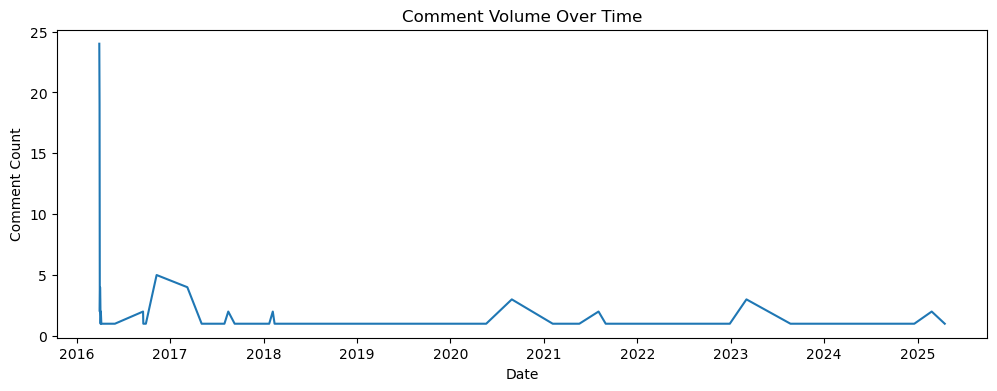

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

# Flatten all comments and replies
def extract_comments(video):
    all_comments = []
    for c in video.get("comments", []):
        c["parent"] = video["video_id"]
        all_comments.append(c)
        for r in c.get("replies", []):
            r["parent"] = c["text"][:30]
            all_comments.append(r)
    return all_comments

comments = extract_comments(video)
df = pd.DataFrame(comments)
df['published_at'] = pd.to_datetime(df['published_at'])

# Plot comment frequency over time
df['published_at'].dt.date.value_counts().sort_index().plot(kind='line', figsize=(12, 4))
plt.title("Comment Volume Over Time")
plt.xlabel("Date")
plt.ylabel("Comment Count")
plt.show()


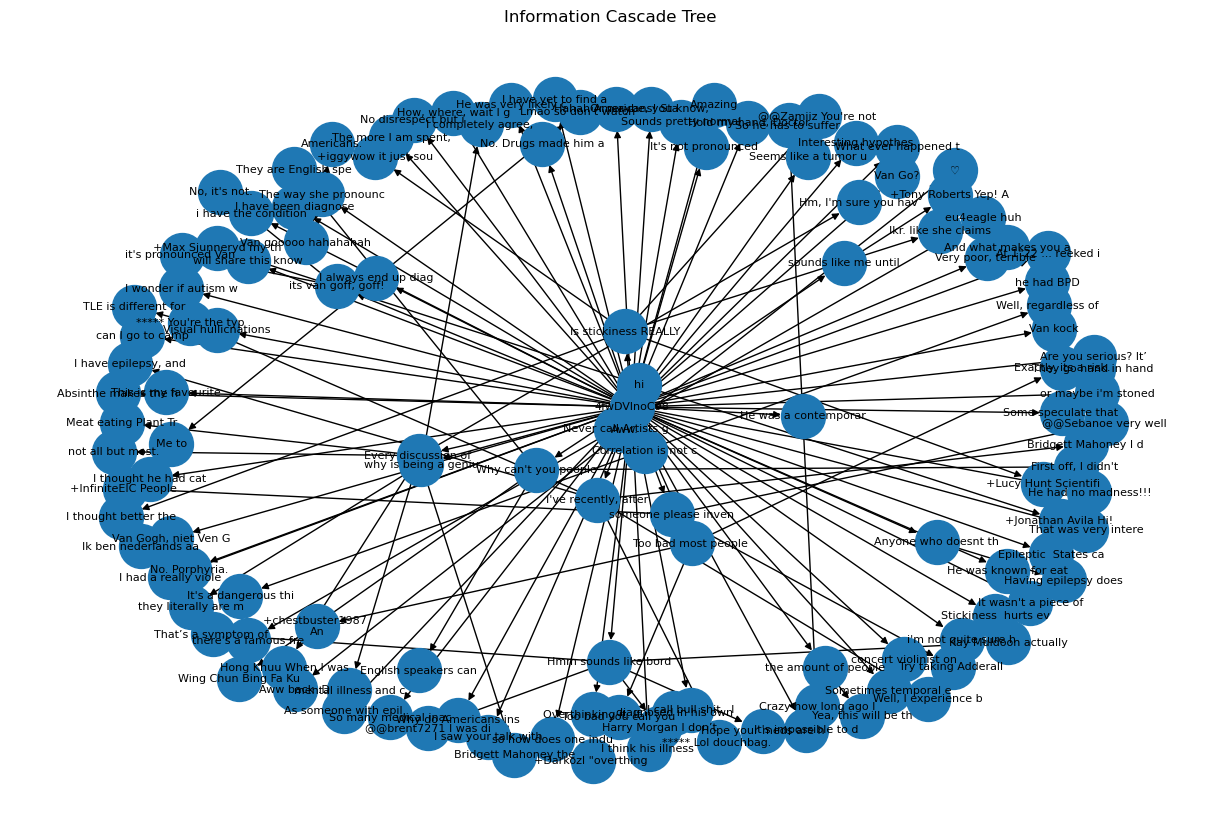

In [3]:
import networkx as nx
import matplotlib.pyplot as plt

G = nx.DiGraph()
G.add_node(video_id, label="Video")

# Reuse extracted comments
for c in comments:
    node_id = c["text"][:20]
    parent = c.get("parent", video_id)
    G.add_node(node_id, label=c.get("author", "Unknown"))
    G.add_edge(parent[:20], node_id)

plt.figure(figsize=(12, 8))
nx.draw(G, with_labels=True, node_size=1000, font_size=8)
plt.title("Information Cascade Tree")
plt.show()


In [5]:

G = nx.DiGraph()  # Directed graph
video = data['youtube'][0]  # one video entry

video_id = video['video_id']
G.add_node(video_id, label="Video", type="video")

# Function to add nodes/edges
def add_comments(comments, parent_id):
    for comment in comments:
        comment_id = comment['text'][:30]  # You can replace this with a hash or unique ID
        G.add_node(comment_id,
                   label=comment.get("author", "Unknown"),
                   text=comment.get("text", "")[:100],
                   type="comment")
        G.add_edge(parent_id, comment_id)

        # Add replies
        if 'replies' in comment:
            for reply in comment['replies']:
                reply_id = reply['text'][:30]
                G.add_node(reply_id,
                           label=reply.get("author", "Unknown"),
                           text=reply.get("text", "")[:100],
                           type="reply")
                G.add_edge(comment_id, reply_id)

# Add main comments and their replies
add_comments(video.get("comments", []), video_id)

# Export to GraphML
nx.write_graphml(G, "van_gogh_cascade.graphml")
print("Exported to van_gogh_cascade.graphml")


Exported to van_gogh_cascade.graphml


3. 🧠 What to Do in Gephi
Step A: Load the file
Open Gephi → File → Open → Select van_gogh_cascade.graphml

Step B: Clean Layout
Choose "Force Atlas 2" or "Yifan Hu" from Layout panel

Run for a few seconds to spread the cascade clearly

Step C: Enhance Insight
Go to Appearance > Nodes > Partition

Color by "type": video, comment, reply

Go to Appearance > Nodes > Ranking

Size by in-degree (number of replies to a comment)

This highlights influential comments

Go to Data Laboratory

View text, author info, and manually inspect threads

Step D: Optional Analytics
Run "Network Diameter" or "Average Path Length" to describe cascade depth

Use "Betweenness Centrality" to detect central bridging replies

In [6]:
import json
import networkx as nx
import uuid

# === Load JSON file ===
with open("youtube_data_vangogh_expanded.json", "r", encoding="utf-8") as f:
    data = json.load(f)

# Get the video data
video = data["youtube"][0]
video_id = video["video_id"]
video_title = video["title"]
video_channel = video["channel_title"]
video_time = video["published_at"]

# === Create directed graph ===
G = nx.DiGraph()

# === Helper: clean problematic text ===
def clean_text(text):
    if text:
        return text.replace("\n", " ").replace("'", "").replace('"', '').strip()
    return ""

# === Add video node ===
G.add_node(video_id,
           label="Video",
           type="video",
           author=video_channel,
           text=clean_text(video_title),
           time=video_time)

# === Recursive function to add comment + reply tree ===
def add_comment_tree(comment, parent_id):
    comment_id = str(uuid.uuid4())  # Unique + clean
    author = comment.get("author", "Unknown")
    text = clean_text(comment.get("text", "")[:100])
    label = clean_text(comment.get("text", "")[:30])
    timestamp = comment.get("published_at", "")

    # Add node
    G.add_node(comment_id,
               label=label,
               type="comment",
               author=author,
               text=text,
               time=timestamp)

    # Add edge from parent
    G.add_edge(parent_id, comment_id)

    # Recursively add replies
    for reply in comment.get("replies", []):
        add_comment_tree(reply, comment_id)

# === Process top-level comments ===
for comment in video.get("comments", []):
    add_comment_tree(comment, video_id)

# === Export to GraphML ===
nx.write_graphml(G, "van_gogh_clean.graphml")
print("✅ Exported clean GraphML for Gephi: van_gogh_clean.graphml")


✅ Exported clean GraphML for Gephi: van_gogh_clean.graphml
